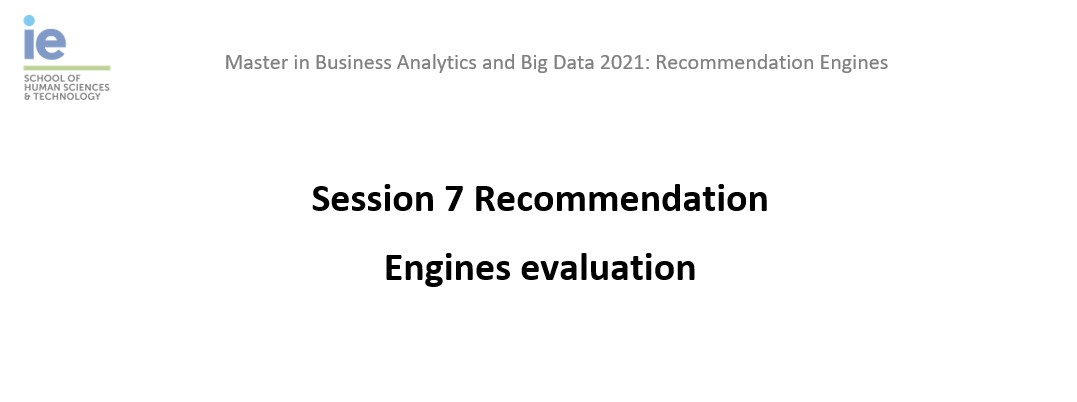

# $$
Group F
$$

# Splitting the dataset

To evaluate models, we need to build them with some data and test them on some
other data. The surprise package contains prebuilt tools that help us in this task.

The target is to define two datasets, which are as follows:
- **Training set:** This set includes users from which the model learns
- **Test set:** This set includes users to whom we recommend movies

As we saw in session 6 in order to measure model's perfomance is important to have clear if we are using either a **classification (like/dislike) or regression(ratings) approach. Because performance metrics are dependant on the  approach choosen.** 


## Simple split

The easiest way to build a training and test set is to split the data in two parts. First, we need to decide how many users to put into each part. For instance, we can put 80 percent of the users into the training set. We can define percentage_training by specifying the percentage of the training set:

In [1]:
# pip install surprise

In [5]:
import pandas as pd
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline

from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import cross_validate

In [7]:
path_ratings = 'ratings.csv' # Your file path here.
path_movies = 'movies.csv' # Your file path here.

movielens = pd.read_csv(path_ratings)
movielens_meta = pd.read_csv(path_movies)
data = movielens.merge(movielens_meta,on='movieId', how='left')
data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [8]:
reader = Reader()
data_surp = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data_surp, test_size=.20)

Here you have two ways of recreating the ratings dataframe from trainset and testset:

In [9]:
test_df=pd.DataFrame(testset, columns=['uid', 'iid', 'rating'])

In [10]:
import pandas as pd

def invert_dictionary(dictionary):
    """Invert a dictionary
    Args: 
        dictionary (dict): A dictionary
    Returns:
        dict: inverted dictionary
    """
    return {v: k for k, v in dictionary.items()}

def surprise_trainset_to_df(trainset, col_user="uid", col_item="iid", col_rating="rating"): 
    df = pd.DataFrame(trainset.all_ratings(), columns=[col_user, col_item, col_rating])
    map_user = trainset._inner2raw_id_users if trainset._inner2raw_id_users is not None else invert_dictionary(trainset._raw2inner_id_users)
    map_item = trainset._inner2raw_id_items if trainset._inner2raw_id_items is not None else invert_dictionary(trainset._raw2inner_id_items)
    df[col_user] = df[col_user].map(map_user)
    df[col_item] = df[col_item].map(map_item)
    return df
train_df=surprise_trainset_to_df(trainset)
train_df.head()

,uid,iid,rating
0,610,142366,3.0
1,610,3925,5.0
2,610,6874,4.5
3,610,85179,4.0
4,610,134853,3.5


### Exercise 1

Check if both dataset training and test have a similar distribution (histogram)

In [11]:
import matplotlib.pyplot as plt

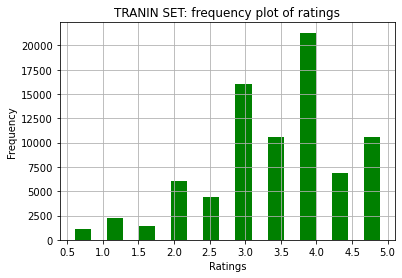

In [12]:
## INSERT AND IMPLEMENT YOUR CODE HERE
plt.hist(train_df.rating, bins = 10, rwidth=0.5, color = 'green') 
plt.xlabel('Ratings') 
plt.ylabel('Frequency')
plt.title('TRANIN SET: frequency plot of ratings')
plt.grid(True)
plt.xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])

plt.show()

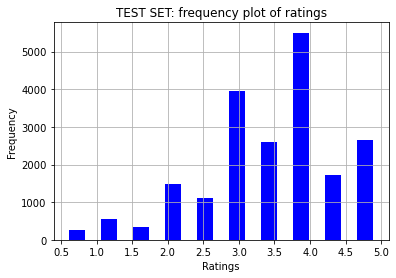

In [13]:
## INSERT AND IMPLEMENT YOUR CODE HERE
plt.hist(test_df.rating, bins = 10, rwidth=0.5, color = 'blue') 
plt.xlabel('Ratings') 
plt.ylabel('Frequency')
plt.title('TEST SET: frequency plot of ratings')
plt.grid(True)
plt.xticks([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])

plt.show()

## K-fold validation 


The previous approach tested the recommender on part of the users. If, instead, we test the recommendation on each user, we could measure the
performances much more accurately. We can split the data into some chunks, take a chunk out as the test set, and evaluate the accuracy. Then, we can do the same with each other chunk and compute the average accuracy. This approach is called k-fold
and it's supported by surprise.

An example a k-fold validation wiht K=5 is provided below. 
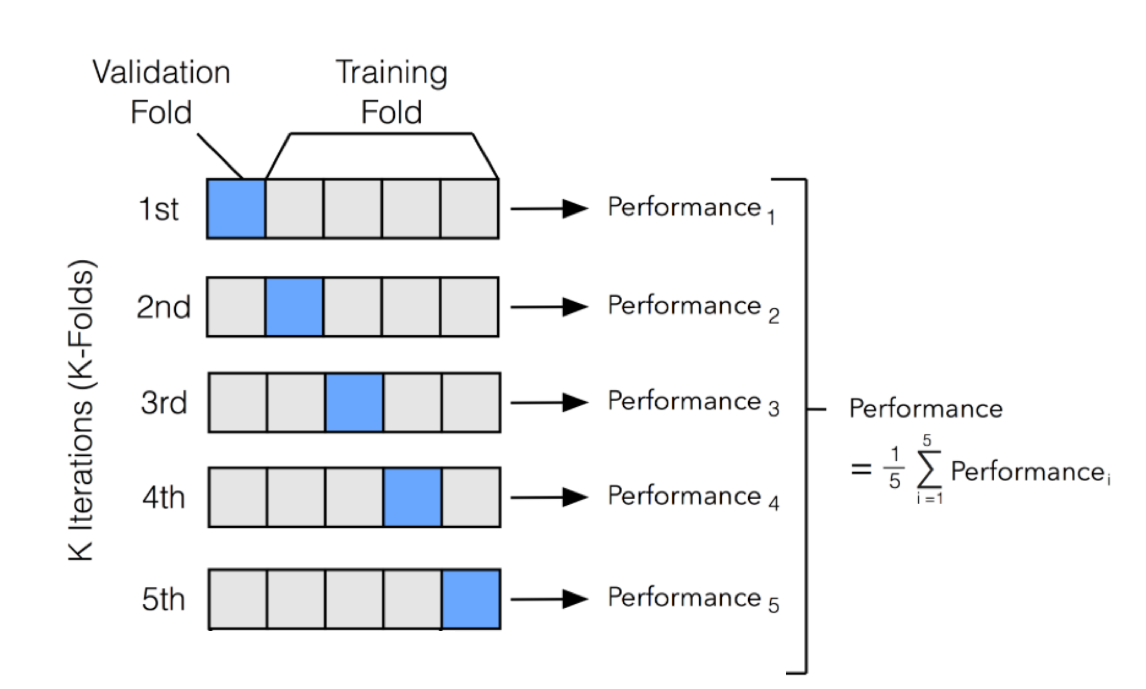

Here is an example where we use a classical K-fold cross-validation procedure with 3 splits:

In [14]:
from surprise.model_selection import KFold
kf = KFold(n_splits=3)

alg = KNNBasic()

for trainset, testset in kf.split(data_surp):

    # train and test algorithm.
    alg.fit(trainset)
    predictions = alg.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9629
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9548
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9528


### Exercise 2
In previous code we split our original dataset using a k-fold validation schema, k=3. Can you create a leave one out schema?
Tip: Use LeaveOneOut from model_selection

In [15]:
## INSERT CODE HERE
from surprise.model_selection import LeaveOneOut

loo = LeaveOneOut(n_splits=3)

alg = KNNBasic()

for trainset, testset in loo.split(data_surp):

    # train and test algorithm.
    alg.fit(trainset)
    predictions = alg.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9250
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9788
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9785


# Evaluation Recommenders

To measure the accuracy we can use the following:
- Root mean square error (RMSE): This is the standard deviation of the difference between the real and predicted ratings (errors).
\begin{equation} 
RMSE = \sqrt{\frac{\sum_{i=1}^{N}{e_i^2}}{N}}
\end{equation}
- Mean squared error (MSE): This is the mean of the squared difference between the real and predicted ratings. It's the square of RMSE, so it contains
the same information
\begin{equation} 
MSE = \frac{\sum_{i=1}^{N}{({e})^2}}{N}
\end{equation}
- Mean absolute error (MAE): This is the mean of the absolute difference between the real and predicted ratings.
\begin{equation} 
\frac{1}{n}\sum_{i=1}^{N}|e_i|
\end{equation} 

One example on how to do it is the following:

In [16]:
knn = KNNBasic()
predictions = knn.fit(trainset).test(testset)
accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9785


0.9785245316232296

## Exercise 3
Change the accuracy metric to MAE and explain the difference.

In [17]:
#Insert your code here
knn = KNNBasic()
predictions = knn.fit(trainset).test(testset)
accuracy.mae(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.7451


0.7451133377277843

##### Explanation: RMSE vs MAE
MAE measures the average magnitude of the errors in a set of predictions without considering their direction. Hence, all individual differences have EQUAL WEIGHT.

RMSE is the square root of the average of squared differences between predictions and observations.

Comparison:
RMSE gives a relatively high weight to large errors, making it more useful when errors are large.

In this case:
Our model has unevenly distributed errors, making the RMSE (weighted) and the MAE (unweighted) very different. This is normal. This will be further explained by the following exercices.

## Exercise 4
Compute these measures for each user

In [19]:
#Insert your code here
predictions_df = pd.DataFrame(predictions).drop(columns=['details'])
predictions_df['error'] = predictions_df['r_ui'] - predictions_df['est']
predictions_df

,uid,iid,r_ui,est,error
0,1,223,3.0,3.989762,-0.989762
1,2,89774,5.0,3.550188,1.449812
2,3,2090,0.5,3.436015,-2.936015
3,4,1517,4.0,3.627216,0.372784
4,5,597,3.0,3.411081,-0.411081
...,...,...,...,...,...
605,606,2481,4.0,3.500708,0.499292
606,607,153,3.0,3.240169,-0.240169
607,608,3257,2.5,2.824315,-0.324315
608,609,208,3.0,3.124757,-0.124757


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def rmse_mae(g):
    mae = mean_absolute_error(g['r_ui'], g['est'])
    rmse = np.sqrt(mean_squared_error(g['r_ui'], g['est'])) # Or should it be that ? : rmse = mean_squared_error(g['r_ui'], g['est'])
    return pd.Series(dict(rmse=rmse, mae=mae))

grouped_pred_df = predictions_df.groupby('uid').apply(rmse_mae).reset_index()
grouped_pred_df

,uid,rmse,mae
0,1,0.989762,0.989762
1,2,1.449812,1.449812
2,3,2.936015,2.936015
3,4,0.372784,0.372784
4,5,0.411081,0.411081
...,...,...,...
605,606,0.499292,0.499292
606,607,0.240169,0.240169
607,608,0.324315,0.324315
608,609,0.124757,0.124757


## Exercise 5

Draw a distribution graph of the errors. Comment the results

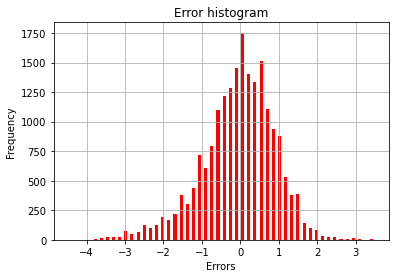

In [53]:
## INSERT CODE HERE
plt.hist(predictions_df.error, bins = 50, rwidth=0.5, color = 'red') 
plt.xlabel('Errors') 
plt.ylabel('Frequency ')
plt.title('Error histogram')
plt.grid(True)

plt.show()

##### Explanation: error distribution
As explained in Exercise 3, the distribution of the errors dictates the difference between RMSE and MAE. If the errors were evenly distributed, RMSE would be the same as MAE. In this case, we can clearly see that the errors are not evenly distributed, hence the big difference between RMSE and MAE. It seems that errors are normally distributed, which is good news in general.

# Evaluating the recommendation


Another way to measure accuracies is by comparing the recommendations with the purchases having a positive rating. Weneed to define a threshold for positive ratings

Let's recap the metrics for classification. 

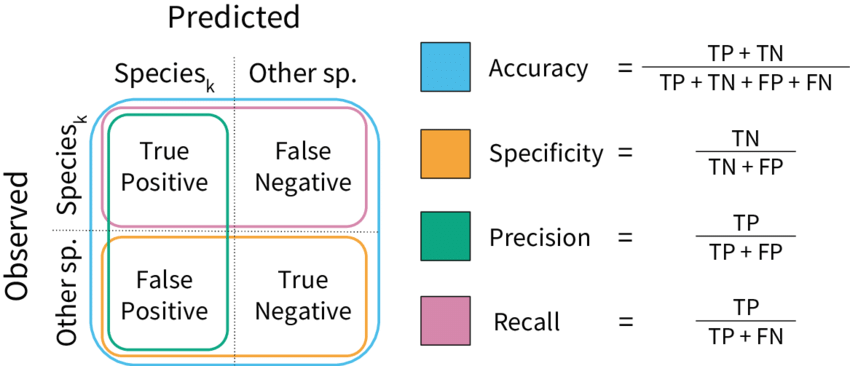

First, let's build the ROC curve. It displays these factors:
- **True Positive Rate (TPR):** This is the percentage of rated items that have been recommended. It's the number of TP divided by the number of rated items (TP + FN).
- **False Positive Rate (FPR)**: This is the percentage of not rated items that have been recommended. It's the number of FP divided by the number of not
rated items (FP + TN).

- **Precision:** This is the percentage of recommended items that have been rated. It's the number of FP divided by the total number of positives (TP + FP).
- **Recall:** This is the percentage of purchased items that have been recommended. It's the number of TP divided by the total number of rated (TP + FN). It's also equal to the True Positive Rate.

In [55]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [56]:
from surprise import KNNBasic
from surprise.model_selection import KFold


kf = KFold(n_splits=5)
alg = KNNBasic()

for trainset, testset in kf.split(data_surp):
    alg.fit(trainset)
    predictions = alg.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.1)

    # Precision and recall can then be averaged over all users
    print("Precision:"+str(sum(prec for prec in precisions.values()) / len(precisions)))
    print("Recall:"+str(sum(rec for rec in recalls.values()) / len(recalls)))
    

Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.764422550629449
Recall:0.45350063211436664
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7661193212917374
Recall:0.4454965712393376
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7671311475409864
Recall:0.4525915675626625
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7523262178434613
Recall:0.45635612651355056
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7715300546448111
Recall:0.4563777996585183


## Exercise 6
Change the previous code to increase the Recall. Explain your results

We got a Recall of around 0.45 with k=5. Now let's try it with k=1:

In [18]:
#Insert your code here
kf = KFold(n_splits=5)
alg = KNNBasic()

for trainset, testset in kf.split(data_surp):
    alg.fit(trainset)
    predictions = alg.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=1, threshold=3.1)

    # Precision and recall can then be averaged over all users
    print("Precision:"+str(sum(prec for prec in precisions.values()) / len(precisions)))
    print("Recall:"+str(sum(rec for rec in recalls.values()) / len(recalls)))
    

Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.8163934426229508
Recall:0.12809131741082577
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.8016393442622951
Recall:0.13485659887186674
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7865353037766831
Recall:0.1280007937712468
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.8095238095238095
Recall:0.13282144189008377
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.825944170771757
Recall:0.12678308781837824


With k=1, Recall decreases to around 0.11. No let's try with k=10:

In [19]:
#Insert your code here
kf = KFold(n_splits=5)
alg = KNNBasic()

for trainset, testset in kf.split(data_surp):
    alg.fit(trainset)
    predictions = alg.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=3.1)

    # Precision and recall can then be averaged over all users
    print("Precision:"+str(sum(prec for prec in precisions.values()) / len(precisions)))
    print("Recall:"+str(sum(rec for rec in recalls.values()) / len(recalls)))

Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7314345661636316
Recall:0.6278746861265959
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7463008575077545
Recall:0.6186288036323211
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7452992453812118
Recall:0.6277713394616771
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7490899037210512
Recall:0.6257809424329562
Computing the msd similarity matrix...
Done computing similarity matrix.
Precision:0.7439505304037327
Recall:0.6232498679672084


With k=10, Recall shoots up to around 0.61.

##### Explanation: increased Recall
From before:
**Recall:** This is the percentage of purchased items that have been recommended. TP / (TP + FN). 

As we increase the top k recommended items (the value of k), the share of True Positives (TP) out of All Positives (TP+FN) increases as well. This is because, as we recomend more items, the total number of Negatives (and consequently the number of FN) decreases. The denominator decreases, tho whole ratio increases.

## Comparing models and identifying the best

In order to evaluate different models, we can define a list with them. 

In [22]:
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBasic(),KNNBasic(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]:
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

,test_rmse,fit_time,test_time
Algorithm,,,
KNNWithZScore,0.900549,0.150093,2.111749
KNNWithMeans,0.904514,0.093434,1.901163
KNNBasic,0.957326,0.092645,1.865220
KNNBasic,0.958231,0.076894,1.823512
KNNBasic,0.958800,0.091018,1.702307


## Exercise 7
Compute the benchmark using the best 
options you got in your parameter tunning for each algorithm

In [23]:
#Insert your code here
benchmark = pd.DataFrame(benchmark)
benchmark

,test_rmse,fit_time,test_time,Algorithm
0,0.957326,0.092645,1.865220,KNNBasic
1,0.958231,0.076894,1.823512,KNNBasic
2,0.958800,0.091018,1.702307,KNNBasic
3,0.904514,0.093434,1.901163,KNNWithMeans
4,0.900549,0.150093,2.111749,KNNWithZScore


In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBasic(),KNNBasic(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]: 
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE'], cv=20, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBasic(k=40, min_k=1),KNNBasic(k=20, min_k=1), KNNBasic(k=10, min_k=1), KNNWithMeans(), KNNWithZScore(k=50)]: 
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE'], cv=20, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

From now on, to speed up the computing process of each iteration, we are only going to test KNNWithZScore changes because we observed that KNNWithZScore outperforms the other algorithms.

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBasic(k=40), KNNWithZScore(k=60)]: 
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE'], cv=20, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBasic(k=40), KNNWithZScore(k=100)]: 
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE'], cv=20, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBasic(k=40), KNNWithZScore(k=80)]: 
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE'], cv=20, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBasic(k=60), KNNWithZScore(k=65)]: 
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE'], cv=20, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBasic(k=30), KNNWithZScore(k=55)]: 
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE'], cv=20, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

### `Comment`
After tweaking different parameters, we can conclude that regardless of the parameters of the algorithms, KNNWithZScore outperforms KNNBasic everytime. 
Also, we found out that the best number of K for KNNWithZScore is around 55, and the best number of folds is around 20.

## Exercise 8
Obtain the best algorithm you can using what you have learnt and any other resource you want.

In [22]:
#Insert your code here
benchmark = []
# Iterate over all algorithms
for algorithm in [KNNBasic(k=30), KNNWithZScore(k=55)]: 
    # Perform cross validation
    results = cross_validate(algorithm, data_surp, measures=['RMSE'], cv=20, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

## `Comment`
We are not getting the exact same result as in Ex7 with the same parameters because we didn't specify a seed for the benchmark.
Anyway, we think that this algorithm is the most efficient based from our results from benchmark (Ex7)

# Content based
Content based algorithms use the content and descriptions of the products/items. In the case of films we can use the tags, genres, year of production, etc. to predict the rating of a user u to an item i.

We can create a training matrix in the way we are used to for machine learning problems or we can use different types of distances.

In this case we are using the tags for the films which are in the genome-scores and genome-tags files. 

## Exercise 9
Read them and create a dataframe df_tags with the following format:
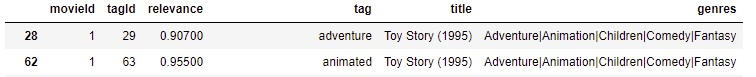

In [25]:
#Insert your code here
path_scores = "genome-scores.csv" # Your file path here.
path_tags = "genome-tags.csv" # Your file path here.
path_movies = "movies.csv" # Your file path here.

genome_scores = pd.read_csv(path_scores)
genome_tags = pd.read_csv(path_tags)
movies = pd.read_csv(path_movies)

In [26]:
all_genomes = genome_scores.merge(genome_tags,on='tagId', how='left')
df_tags = all_genomes.merge(movies, on='movieId', how='left')
df_tags.sort_values(by='movieId').head()

,movieId,tagId,relevance,tag,title,genres
0,1,1,0.02900,007,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
742,1,743,0.75475,original plot,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
743,1,744,0.03750,orphans,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
744,1,745,0.60125,oscar,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
745,1,746,0.11975,oscar (best actor),Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


## Exercise 10
Inspect the dataframe for movieId==1 (Toy Story). Do you think all the tags are useful?

In [27]:
#Insert your code here
toy_story_df = df_tags[df_tags.movieId==1]
toy_story_df.sort_values(by='relevance')

,movieId,tagId,relevance,tag,title,genres
1001,1,1002,0.00200,swedish,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
488,1,489,0.00225,hannibal lecter,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1068,1,1069,0.00300,vampires,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
592,1,593,0.00350,kurosawa,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
975,1,976,0.00375,studio ghibli,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
588,1,589,0.98850,kids and family,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
63,1,64,0.98875,animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
785,1,786,0.99550,pixar animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
243,1,244,0.99900,computer animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [28]:
toy_story_df.tag.nunique()

1128

As they are, tags are completely useless. There are 1128 rows in toy_story_df and there are 1128 tags... Some tags correspond to Toy Story, whereas some are completely off (like 'zombies', 'wwii', or '18th century').

## Exercise 11

Solve the previous problem to reduce data and explain the solution.

In [29]:
#Insert your code here
toy_story_df.genres.nunique()

1

The genre is the same for all the rows so we can just drop them out...

In [30]:
toy_story_df.drop(columns=['genres'])

,movieId,tagId,relevance,tag,title
0,1,1,0.02900,007,Toy Story (1995)
1,1,2,0.02375,007 (series),Toy Story (1995)
2,1,3,0.05425,18th century,Toy Story (1995)
3,1,4,0.06875,1920s,Toy Story (1995)
4,1,5,0.16000,1930s,Toy Story (1995)
...,...,...,...,...,...
1123,1,1124,0.04550,writing,Toy Story (1995)
1124,1,1125,0.02000,wuxia,Toy Story (1995)
1125,1,1126,0.03850,wwii,Toy Story (1995)
1126,1,1127,0.09125,zombie,Toy Story (1995)


Our idea now is to use the relevance of the tag to "treat" those tags with a relevance under a specific threshold. To identify this threshold, it is a good idea to plot the distribution of relevance:

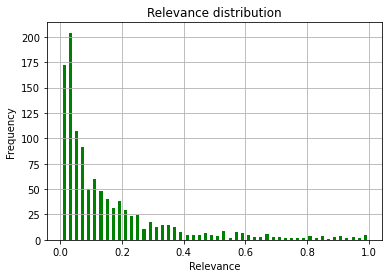

In [31]:
## INSERT CODE HERE
plt.hist(toy_story_df.relevance, bins = 50, rwidth=0.5, color = 'green') 
plt.xlabel('Relevance') 
plt.ylabel('Frequency ')
plt.title('Relevance distribution')
plt.grid(True)

plt.show()

After seeing the plot and reading the corresponding tags, we have decided that our relevance threshold is 0.3.

Idea: we will replace all "irrelevant" tags with the most relevant tag ("toys"). We believe that the most relevant tag is the one that describes the movie most accurately. 

We preferred to do this instead of just dropping all rows with relevance under the threshold, because that would significantly reduce the dataset. See plot above.

In [32]:
toy_story_df.loc[toy_story_df['relevance'] < 0.3, 'tag'] = "toys"
toy_story_df.sort_values(by='relevance')

/Users/stanislasdefoucault/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,movieId,tagId,relevance,tag,title,genres
1001,1,1002,0.00200,toys,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
488,1,489,0.00225,toys,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1068,1,1069,0.00300,toys,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
592,1,593,0.00350,toys,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
975,1,976,0.00375,toys,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
588,1,589,0.98850,kids and family,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
63,1,64,0.98875,animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
785,1,786,0.99550,pixar animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
243,1,244,0.99900,computer animation,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


### `Comment`

Now, for the movie `Toy Story`, all the rows where the relevance is lower than 0.3 have the tag with the most relevance : `toys`. 
We doncan assume that we don't have unrelevant tags anymore.

# NLP methods

We are going to create the model using the tags and some Natural Language Processing methods to convert the words into vectors to create a metric to compare between those words. We are going to use the packages: gensim and nltk for this purpose.

In [36]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
tags_corpus = df_tags.tag.values

In [62]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stanislasdefoucault/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/stanislasdefoucault/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [34]:
stop_words = stopwords.words('english')

# tokenize document and clean
def word_tokenize_clean(doc):
  
  # split into lower case word tokens
    tokens = word_tokenize(doc.lower())
  
  # remove tokens that are not alphabetic (including punctuation) and not a stop word
    tokens = [word for word in tokens if word.isalpha() and not word in stop_words]
  
    return tokens

We create a list of Documments. Each document represents a film and it has the tags of that film. 

In [35]:
tags_doc = [TaggedDocument(words=word_tokenize_clean(D), tags=[str(i)]) for i, D in enumerate(tags_corpus)]

We are using Doc2Vec to create a vector representation of each film

In [36]:
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm=0) # paragraph vector distributed bag-of-words (PV-DBOW)

model.build_vocab(tags_doc)

We train the model to represent the films in vectors.

In [37]:
max_epochs = 10

for epoch in range(max_epochs):
    print(epoch, end = ' ')
    model.train(tags_doc,
              total_examples=model.corpus_count,
              epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

0 1 2 3 4 5 6 7 8 9 

We compare films by measuring distances among vectors.

In [40]:
mv = 'Toy Story (1995)'
tags_vectors = model.docvecs.vectors_docs
mv_index = df_tags[df_tags["title"] == mv].index.values[0]

print(tags_vectors[mv_index])

sims = model.docvecs.most_similar(positive = [mv_index], topn = 30)

for i, j in sims:
    print(int(i))
    print(df_tags.loc[int(i), "title"].strip())

<ipython-input-40-b52242f3032e>:2: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  tags_vectors = model.docvecs.vectors_docs


AttributeError: 'KeyedVectors' object has no attribute 'vectors_docs'

# Optional

Create any other model that you think could be useful.

For example, you could create a training matrix for predicting the rating as if you were in a machine learning problem. Evaluate your results

### linear regression model to predict the ratings.

According to the way a user rates the movies (mean, std), and the films he has rated well or badly, we can try to predict with a confidence interval the rating he would give to a film he has not yet seen.